In [1]:
import numpy as np
import random
import os
import keras_tuner as kt
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as layers
from tensorflow.keras.layers import GlobalMaxPooling2D, Activation, Dense, Conv1D, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras import optimizers
import pandas as pd
from tqdm.notebook import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy import signal

from utils.augment import augment
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

from utils.deep import preProcess, smoothLabels, oneHot, applyOneHot, evaluate_set
from utils.visualize import showMe, showHistory


%load_ext autoreload
%autoreload 2


C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [101]:
classes = ['Rest', 'Eyebrow','Smile', 'Chew']
classes = ['Rest', 'Chew']

batch_size = 32
input_length = 300
#input_length = 100
root_path = 'resources/'
#post_fix = '_1s_augmented'
post_fix = '_3s'
exclude =  ['S011'] #['S002', 'S009', 'S011']
exclude_last = ['S001', 'S006', 'S007']
include = ['S010']

# use session4 for validation
train_sessions = []
val_sessions = []
for subject in os.listdir(root_path):
    #if subject not in exclude:
    if subject in include:
        for session in os.listdir(os.path.join(root_path,subject)):
            if session == 'session_4':
                val_sessions.append(os.path.join(root_path,subject, session))
            else:
                train_sessions.append(os.path.join(root_path,subject, session))
        #print(f"{len(os.listdir(os.path.join(root_path,subject)))} session loaded from subject: {subject}")
print(f"{len(train_sessions)} sessions loaded for training")
print(f"{len(val_sessions)} sessions loaded for validation")

records = {}
for c in classes:
    class_data = []
    for session in train_sessions:
        class_data.append(np.load(os.path.join(session,c+post_fix+'.npy'),allow_pickle=True))
    records[c] = np.concatenate(class_data)

val_records = {}
for c in classes:
    class_data = []
    for session in val_sessions:
        class_data.append(np.load(os.path.join(session,c+post_fix+'.npy'),allow_pickle=True))
    val_records[c] = np.concatenate(class_data)
    
# test_sessions = []
# for subject in os.listdir(root_path):
#     if subject not in exclude:
#         for session in os.listdir(os.path.join(root_path,subject)):
#             if session == 'session_4' and subject in exclude_last:
#                 test_sessions.append(os.path.join(root_path,subject, session))
# print(f"{len(test_sessions)} session loaded for testing")



3 sessions loaded for training
1 sessions loaded for validation


In [111]:
X = np.concatenate((list(records.values())),axis = 0)
val_X= np.concatenate((list(val_records.values())),axis = 0)

# ezt szedd ki
# clip_value = 2000
# X = signal.resample(X, input_length, axis = -1)
# X = np.clip(X, -clip_value, clip_value) 
# X /= clip_value


# val_X = signal.resample(val_X, input_length, axis = -1)
# val_X = np.clip(val_X, -clip_value, clip_value) 
# val_X /= clip_value

s = records['Rest'].shape[0]
#y = np.concatenate(( np.zeros(s),np.ones(s),np.ones(s)*2,np.ones(s)*3))
y = np.concatenate(( np.zeros(s),np.ones(s)))


val_s = val_records['Rest'].shape[0]
#val_y = np.concatenate(( np.zeros(val_s),np.ones(val_s),np.ones(val_s)*2,np.ones(val_s)*3))
val_y = np.concatenate(( np.zeros(val_s),np.ones(val_s)))



#SHUFFLE DATA
c = list(zip(X, y))
random.shuffle(c)
X,y = zip(*c)
X = np.array(X)
y = np.array(y)

y = applyOneHot(y,len(classes))
val_y = applyOneHot(val_y,len(classes))

print(X.shape)
print(y.shape)

print(val_X.shape)
print(val_y.shape)


(150, 6, 1500)
(150, 2)
(50, 6, 1500)
(50, 2)


In [131]:
X = np.array([preProcess(s) for s in X])
val_X = np.array([preProcess(s) for s in val_X])


#AUGMENT
X_aug, y_aug = augment(X, y)

print(X_aug.shape)
print(y_aug.shape)

(300, 6, 1500)
(300, 2)


In [132]:
def get_dense_model():
    inspected_chanels= X.shape[1]
    input_length=     X.shape[2]
    input_layer = keras.Input(shape = (inspected_chanels,input_length,1), name='input')
    x = layers.Flatten()(input_layer)

    l2 = 0.0001
   

    x     = layers.Dense(1000,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    x     = layers.Flatten()(x)

    x     = layers.Dense(200,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)


    x     = layers.Dense(100,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)



    x     = layers.Dense(50,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    #x     = layers.Dropout(.1)(x)


    x     = layers.Dense(30,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)



    x     = layers.Dense(10,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    x     = layers.Dropout(.2)(x)


    output = layers.Dense(len(classes), activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output)

    model.summary()
    return model

In [133]:
def get_model():
    inspected_chanels= X.shape[1]
    input_length=     X.shape[2]
    input_layer = keras.Input(shape = (inspected_chanels,input_length,1), name='input')
    #x = layers.Flatten()(input_layer)

    l2 = 0.0001
   
    x     = layers.Conv2D(128, kernel_size=(6,6), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2))(input_layer)
    x     = layers.BatchNormalization()(x)
    x     = layers.AveragePooling2D(pool_size=(1,5))(x)


    # x     = layers.Dense(1000,kernel_regularizer=regularizers.l2(l2))(x)
    # x     = layers.BatchNormalization()(x)
    # #x     = layers.Flatten()(x)

   

    # x     = layers.Dense(500,kernel_regularizer=regularizers.l2(l2))(x)
    # x     = layers.BatchNormalization()(x)

    # x     = layers.Dense(200,kernel_regularizer=regularizers.l2(l2))(x)
    # x     = layers.BatchNormalization()(x)

    

    # x     = layers.Dense(100,kernel_regularizer=regularizers.l2(l2))(x)
    # x     = layers.BatchNormalization()(x)
    # x     = layers.Dropout(.2)(x)

    
    
    

    x     = layers.Flatten()(x)

    x     = layers.Dense(10,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    x     = layers.Dropout(.2)(x)


    output = layers.Dense(len(classes), activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output)

    model.summary()
    return model

In [9]:
def get_hyper_model(hp):
    model = keras.Sequential()
    inspected_chanels= X.shape[1]
    input_length=     X.shape[2]
    input_layer = keras.Input(shape = (inspected_chanels,input_length), name='input')
    x = layers.Flatten()(input_layer)
    l2 = 0.001
    for i in range(hp.Choice('n_layers',[4,6, 10, 20])):
        x     = layers.Dense(hp.Int('dense',min_value=100,max_value=10000,sampling="log"),kernel_regularizer=regularizers.l2(l2))(x)
        x     = layers.BatchNormalization()(x)
        x     = layers.Dropout(hp.Choice('dropout',[0., 0.1]))(x)


    output = layers.Dense(len(classes), activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output)


    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log"),
        decay_steps=batch_size*10,
        decay_rate=hp.Choice('decay',[0.1,0.9]))


    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=lr_schedule),
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"],
    )
    model.summary()
    return model

In [134]:
model = get_dense_model()
#model = get_model()


# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=3, min_lr=1e-6, min_delta = 0.0001)
                              
# early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.000001)

opt = keras.optimizers.SGD(learning_rate=1e-5) #, momentum=0.9)
model.compile(optimizer=opt,
          loss='categorical_crossentropy',
          metrics=['categorical_accuracy']
         )


Model: "functional_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 6, 1500, 1)]      0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 9000)              0         
_________________________________________________________________
dense_88 (Dense)             (None, 1000)              9001000   
_________________________________________________________________
batch_normalization_69 (Batc (None, 1000)              4000      
_________________________________________________________________
flatten_34 (Flatten)         (None, 1000)              0         
_________________________________________________________________
dense_89 (Dense)             (None, 200)               200200    
_________________________________________________________________
batch_normalization_70 (Batc (None, 200)             

Batch size: 64
Epoch 1/40
3/3 [==============================] - 0s 98ms/step - loss: 1.3305 - categorical_accuracy: 0.4533 - val_loss: 2.0214 - val_categorical_accuracy: 0.5200
Epoch 2/40
3/3 [==============================] - 0s 13ms/step - loss: 1.3400 - categorical_accuracy: 0.4533 - val_loss: 1.9195 - val_categorical_accuracy: 0.5200
Epoch 3/40
3/3 [==============================] - 0s 14ms/step - loss: 1.3008 - categorical_accuracy: 0.4467 - val_loss: 1.8357 - val_categorical_accuracy: 0.5200
Epoch 4/40
3/3 [==============================] - 0s 14ms/step - loss: 1.2657 - categorical_accuracy: 0.4533 - val_loss: 1.7575 - val_categorical_accuracy: 0.5200
Epoch 5/40
3/3 [==============================] - 0s 14ms/step - loss: 1.2462 - categorical_accuracy: 0.4933 - val_loss: 1.6933 - val_categorical_accuracy: 0.5200
Epoch 6/40
3/3 [==============================] - 0s 14ms/step - loss: 1.2948 - categorical_accuracy: 0.4267 - val_loss: 1.6320 - val_categorical_accuracy: 0.5000
Epoch 7

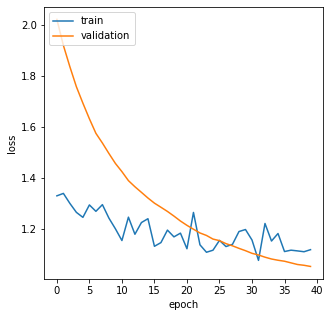

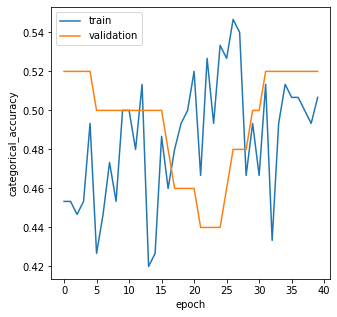

0.5199999809265137


In [135]:
##############################################
############     TRAIN MODEL     #############
##############################################

batch_size = 64# len(val_X)
print("Batch size: {}".format(batch_size))

history = model.fit(X,
                    y,
                    validation_data=(val_X, val_y),
                    batch_size=batch_size,
                    epochs=40,
                    shuffle=True,
                    #callbacks = [reduce_lr]
                    )

showHistory(history)      
try:    
    acc = max(history.history['val_accuracy'])
except:
    acc = max(history.history['val_categorical_accuracy'])

print(acc)

In [ ]:
skf = StratifiedKFold(n_splits=10)
#tf.config.run_functions_eagerly(True)

for train, test in skf.split(X, y.argmax(1)):
  
    X_train = X[train]
    X_test  = X[test]
    y_train = y[train]
    y_test  = y[test]

    #batch_size = 30 #len(X_train)
    print("Batch size: {}".format(batch_size))


    tuner = kt.tuners.RandomSearch(
        get_hyper_model,
        objective='val_accuracy',
        max_trials=100)

    tuner.search(X_train,
                y_train,
                validation_data=(X_test, y_test),
                batch_size=batch_size,
                epochs=20,
                shuffle=True)

    best_model = tuner.get_best_models()[0]
                             
    break
   

In [ ]:
tuner.results_summary()

In [99]:
evaluate_set(model, train_sessions, classes, post_fix, input_length=input_length, log = True)

  0%|          | 0/3 [00:00<?, ?it/s]

####################
Accuracy : 68.0%
[[22  3]
 [13 12]]

####################
Accuracy : 57.99999999999999%
[[13 12]
 [ 9 16]]

####################
Accuracy : 54.0%
[[ 9 16]
 [ 7 18]]

Global accuracy: 59.67%
          Accuracy
Subject           
S001     59.666667


In [100]:
evaluate_set(model, val_sessions, classes,  post_fix, input_length=input_length, log = True)

  0%|          | 0/1 [00:00<?, ?it/s]

####################
Accuracy : 44.0%
[[14 11]
 [17  8]]

Global accuracy: 44.0%
         Accuracy
Subject          
S001           44
